In [2]:
import pandas as pd
import numpy as np
%matplotlib inline


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders


import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("airline_passengers.csv",index_col='Month',parse_dates=True)

In [4]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### 從以下數據的趨勢來看數據為非平穩序列，因此需要透過差分來使數據平穩，才能進行預測

<AxesSubplot:xlabel='Month'>

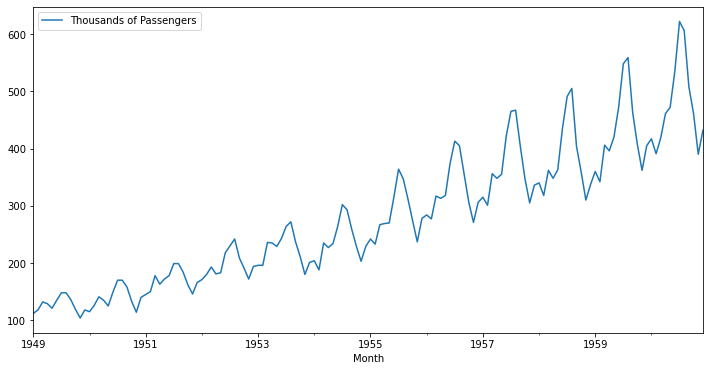

In [5]:
df.plot(figsize=(12,6))

#### 使用ADF Test來檢測數據是否確實為非平穩序列

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

#### ADF-t 檢定是一個左尾檢定, ADF-t 統計量越小, 越能提供證據拒絕 「具有單根」 的虛無假設<br>ADF檢驗的統計量為1%，p值為5%，臨界值為10%<br>如果檢驗統計量小於臨界值，我們可以拒絕原假設(也就是序列是平穩的)。當檢驗統計量大於臨界值時，不能拒絕原假設(這意味著序列不是平穩的)。<br>檢驗統計量>臨界值，這意味著序列不是平穩的。這證實了我們最初在目視檢測中觀察的結果。

In [7]:
adf_test(df['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### 先進行一階差分，完成後檢驗統計量<臨界值，序列已經變為平穩的

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.829267
p-value                   0.054213
# lags used              12.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


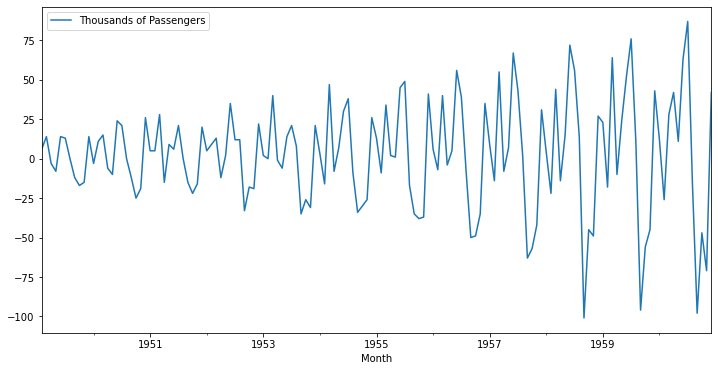

In [8]:
import matplotlib.pyplot as plt 
#一階差分 lags:1,12
diff_1 = df-df.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(12,6), label="diff_1")
plt.legend();

adf_test(diff_1)

#### seasonal_decompose 可以觀察數據有無季節性，從第三張圖看來，是有明顯的季節性

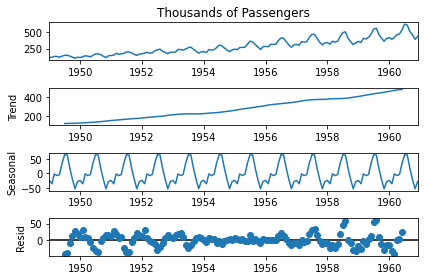

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(df['Thousands of Passengers'], model='add')
result.plot();

#### 透過auto_arima來取得最佳模型的p,d,q，假設將時間序列認定為是沒有季節性的，這裡的最佳模型是SARIMAX(4, 1, 3)

In [10]:
auto_arima(df['Thousands of Passengers'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                -674.913
Date:                Fri, 30 Sep 2022   AIC                           1365.825
Time:                        20:46:59   BIC                           1389.528
Sample:                    01-01-1949   HQIC                          1375.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.332      -0.126       0.374
ar.L4         -0.5213      0.085     -6.136      0.000      -0.688      -0.355
ma.L1          0.9069      0.094      9.657      0.000       0.723       1.091
ma.L2         -0.5590      0.145     -3.866      0.000      -0.842      -0.276
ma.L3         -0.7385      0.109     -6.778      0.000      -0.952      -0.525
sigma2       724.1727     85.616      8.458      0.000     556.369     891.976
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                14.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 將資料分為訓練集和測試集，在用建議的最佳模型(4, 1, 3)來建模，最後預估出來的和實際的落差很大，主要原因是因為忽略了序列是有季節性的，因此需要在重新調整

In [11]:
train = df.iloc[:90]
test = df.iloc[90:]

In [12]:
model = ARIMA(train['Thousands of Passengers'],order=(4,2,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   90
Model:                      ARIMA(4, 2, 3)   Log Likelihood                -383.361
Date:                     Fri, 30 Sep 2022   AIC                            782.722
Time:                             20:54:46   BIC                            802.540
Sample:                         01-01-1949   HQIC                           790.706
                              - 06-01-1956                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4451      0.160     -2.776      0.006      -0.759      -0.131
ar.L2         -0.8151      0.157     -5.203      0.000      -1.122      -0.508
ar.L3          0.1591      0.152      1.047      0.295      -0.139       0.457
ar.L4         -0.3518      0.130     -2.705      0.007      -0.607      -0.097
ma.L1         -0.1784     12.457     -0.014      0.989     -24.594      24.237
ma.L2          0.1612     10.247      0.016      0.987     -19.922      20.244
ma.L3         -0.9823     12.308     -0.080      0.936     -25.106      23.142
sigma2       319.4750   3991.194      0.080      0.936   -7503.121    8142.071
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.63   Prob(JB):                         0.93
Heteroskedasticity (H):               3.34   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(4,2,3) Predictions')

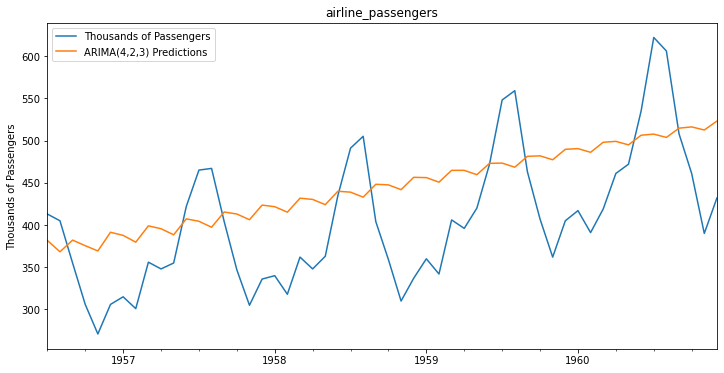

In [14]:
title = 'airline_passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = test['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### 重新加上季節性和週期性seasonal=True,m=12，建議的最佳模型為SARIMAX(2, 1, 1)x(0, 1, [], 12)，在和實際的比對後，發現有比較接近原本的資料趨勢

In [15]:
auto_arima(df['Thousands of Passengers'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Fri, 30 Sep 2022   AIC                           1017.847
Time:                                     20:54:57   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.986      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.599      0.000      -1.057      -0.907
sigma2       129.3177     14.557      8.883      0.000     100.786     157.850
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
len(df)

144

In [17]:
train = df.iloc[:90]
test = df.iloc[90:]

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Thousands of Passengers'],order=(2,1,1),seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19948D+00    |proj g|=  2.34541D-01

At iterate    5    f=  3.16950D+00    |proj g|=  1.68999D-03

At iterate   10    f=  3.16858D+00    |proj g|=  6.09404D-02

At iterate   15    f=  3.16159D+00    |proj g|=  2.23342D-02

At iterate   20    f=  3.15843D+00    |proj g|=  5.07893D-03

At iterate   25    f=  3.15811D+00    |proj g|=  2.20433D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   90
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -284.230
Date:                             Fri, 30 Sep 2022   AIC                            576.460
Time:                                     20:55:13   BIC                            585.835
Sample:                                 01-01-1949   HQIC                           580.210
                                      - 06-01-1956                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6308      0.168      3.745      0.000       0.301       0.961
ar.L2          0.1637      0.137      1.195      0.232      -0.105       0.432
ma.L1         -0.9347      0.151     -6.198      0.000      -1.230      -0.639
sigma2        93.7393     15.328      6.116      0.000      63.697     123.782
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.36
Prob(Q):                              0.94   Prob(JB):                         0.51
Heteroskedasticity (H):               1.64   Skew:                             0.32
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,2)(0,1,0,12) Predictions')

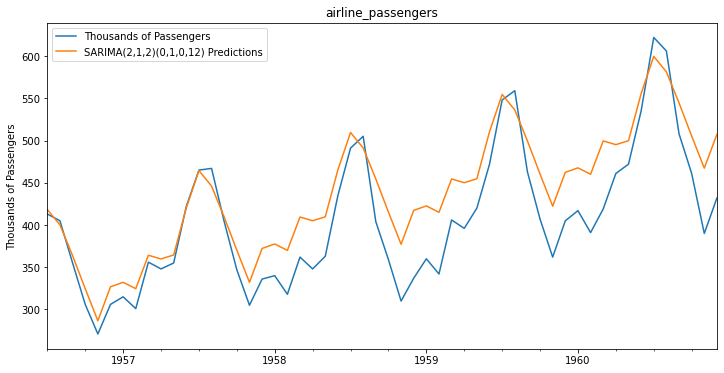

In [20]:
# Plot predictions against known values
title = 'airline_passengers'
ylabel='Thousands of Passengers'
xlabel=''

ax = test['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### 預測後面12個月可能發生的數據

In [21]:
model = SARIMAX(df['Thousands of Passengers'],order=(2,1,1),seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+12,typ='levels').rename('SARIMA(2,1,1)(0,1,0,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57610D+00    |proj g|=  3.04448D-01

At iterate    5    f=  3.52912D+00    |proj g|=  2.12220D-03

At iterate   10    f=  3.52819D+00    |proj g|=  7.65460D-03

At iterate   15    f=  3.52186D+00    |proj g|=  2.59437D-02

At iterate   20    f=  3.51020D+00    |proj g|=  2.55956D-02

At iterate   25    f=  3.50645D+00    |proj g|=  1.46296D-03

At iterate   30    f=  3.50641D+00    |proj g|=  2.99911D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


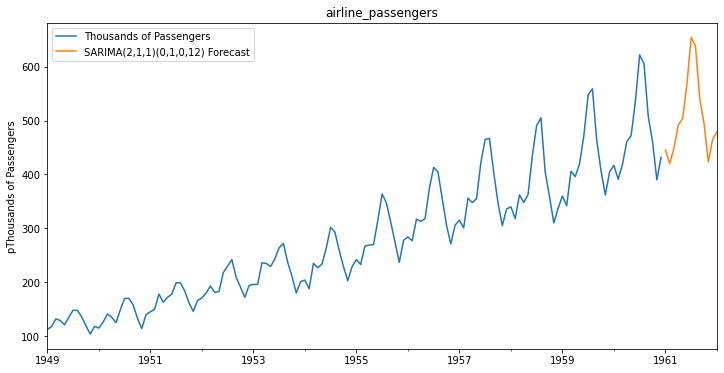

In [22]:
# Plot predictions against known values
title = 'airline_passengers'
ylabel='pThousands of Passengers'
xlabel=''

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);